# Information Bottleneck

In [1]:
import torch.nn as nn
import torch
import torch.nn.functional as F

from compute_MI import compute_MI_binning

In [2]:
import numpy as np 
import matplotlib.pyplot as plt

In [40]:
# load file with weights of the unsupervised part
filename = 'nic_mat.npy'
weights = np.load(filename) 
print('Weights shape, unsupervised part:', weights.shape)

# load file with weights of the supervised part
filename = '...............'
weights_supervised = np.array([0])
print('Weights shape, supervised part:', weights_supervised.shape)

# epochs
nepochs = weights.shape[0]  
print('Number of epochs:', nepochs)

Weights shape, unsupervised part: (5, 2000, 784)
Weights shape, supervised part: (1,)
Number of epochs: 5


In [41]:
# define network
class BioNet_unsupervised(nn.Module):
    def __init__(self,
                 weights,
                 n : float = 4.5):
        
        """
        Simple MNIST classifier initialized with weights from the unsupervised (bio)learning algorithm for the first layer.
        
        Parameters
        ----------
        weights : np.array of shape (hidden_dim, input_dim), where input_dim = 28*28 for the MNIST dataset, and hidden_dim=2000
            Weights computed from unsupervised learning.
        n : float
            Exponent of ReLU
        """
        
        super().__init__()
        self.weights = torch.t(torch.from_numpy(weights)) #shape (output_dim, input_dim) -> (input_dim, output_dim)
        #[Because batch_size is the first dimension of inputs, and so it is convenient to transpose the weights
        #so that a single matrix multiplication works for the entire batch]
        
        self.n = n
        
    def forward(self, inputs : torch.Tensor): # vᵢ: (batch_sz, img_sz)
        """
        Parameters
        ----------
        inputs : torch.Tensor of shape (batch_size, input_dim)
            Batch of input values
        """
        
        out = torch.matmul(inputs, self.weights) 
        out = F.relu(out) ** self.n
        
        return out
    
# define network
class BioNet_complete(nn.Module):
    def __init__(self,
                 weights_hidden,
                 weights_classif,
                 n : float = 4.5,
                 beta : float =.01):
        
        """
        Simple MNIST classifier initialized with weights from the unsupervised (bio)learning algorithm for the first layer.
        
        Parameters
        ----------
        weights_hidden : np.array of shape (hidden_dim, input_dim), where input_dim = 28*28 for the MNIST dataset, and hidden_dim=2000
            Weights computed from unsupervised learning.
            
        weights_classif : np.array of shape (output_dim, hidden_dim), where output_dim = 10 for the MNIST dataset, and hidden_dim=2000
            Weights computed from supervised learning.

        n : float
            Exponent of ReLU
        beta : float
            "Inverse temperature" for tanh activation in the top layer (See equation 1 in [10]).
        """
        
        super().__init__()
        self.weights_hidden = torch.t(torch.from_numpy(weights_hidden)) #shape (output_dim, input_dim) -> (input_dim, output_dim)
        self.weights_classif = torch.t(torch.from_numpy(weights_classif)) #shape (output_dim, input_dim) -> (input_dim, output_dim)
        #[Because batch_size is the first dimension of inputs, and so it is convenient to transpose the weights
        #so that a single matrix multiplication works for the entire batch]
        
        self.n = n
        self.beta = beta
        
        
    def forward(self, inputs : torch.Tensor): # vᵢ: (batch_sz, img_sz)
        """
        Parameters
        ----------
        inputs : torch.Tensor of shape (batch_size, input_dim)
            Batch of input values
        """
        
        out = torch.matmul(inputs, self.weights_hidden) 
        out = F.relu(out) ** self.n
        out = torch.matmul(out, self.weights_classif) 
        out = torch.tanh(self.beta * out)
        
        return out

In [42]:
# import MNIST dataset 
def get_test_data():
    #Test with MNIST dataset 
 
    try: #Load MNIST dataset 
        X = np.load("data/project/MNIST/MNIST_features.npy", allow_pickle=True)[-10000:, :]
        # y = np.load("data/project/MNIST/MNIST_labels.npy", allow_pickle=True)[-subset, :]
        
    except IOError: #If not present, error
        print('data not present') 
    
    return torch.from_numpy(X/255.) #Apply normalization, return torch tensor


In [43]:
# get data
test_X = get_test_data()

# forward step
output_T = []

for i in range(nepochs):
    print('Running epoch %i ...' %i)
    
    model = BioNet_unsupervised(weights[i])
    
    forward_step = model.forward(test_X)
    forward_step = forward_step.detach().numpy()
            
    output_T.append(forward_step)
        
    del model
    
print('Completed!')
    
output_T = np.array(output_T)

print('')
print(output_T.shape)
    

Running epoch 0 ...
Running epoch 1 ...
Running epoch 2 ...
Running epoch 3 ...
Running epoch 4 ...
Completed!

(5, 10000, 2000)


In [44]:
# set binning details
bin_min = 0
bin_max = output_T.max() 

nbins = 100

# run over epochs and store MI
MI_T_X = []

for i in range(nepochs):
    print('Computing MI for epoch %i ...' %i)
    MI_tmp = compute_MI_binning(output_T[i], nbins=nbins, bin_max=bin_max, bin_min=bin_min)
    MI_T_X.append(MI_tmp)
    
print('Completed!')


Computing MI for epoch 0 ...
Computing MI for epoch 1 ...
Computing MI for epoch 2 ...
Computing MI for epoch 3 ...
Computing MI for epoch 4 ...
Completed!


In [ ]:
filename = './MI_output/MI_T_X.npy'
np.save(file=filename, arr=np.array(MI_T_X))

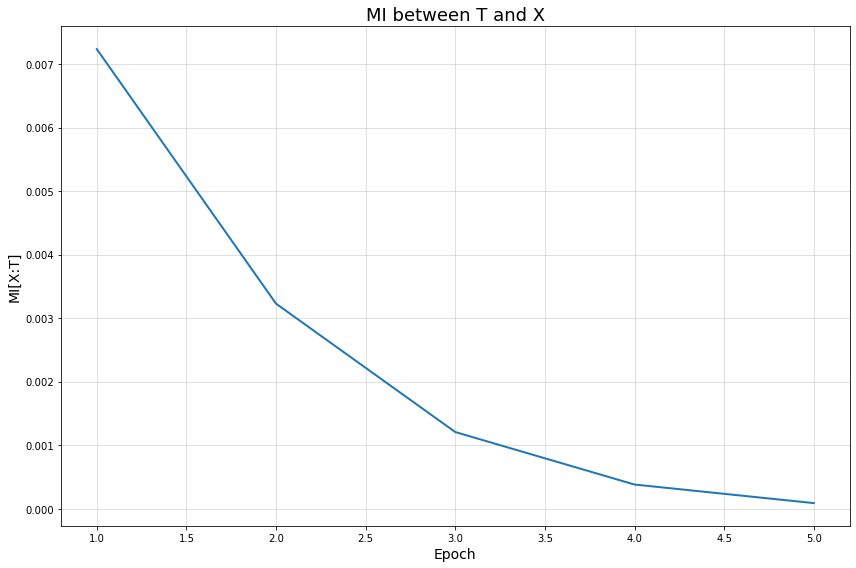

In [45]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(np.arange(1, 1+nepochs), MI_T_X, linewidth=2)
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('MI[X:T]', fontsize=14)
ax.set_title('MI between T and X', fontsize=18)
ax.grid(alpha=0.5)

plt.tight_layout()
plt.show()


## Computation of the MI between layer T and output Y

In [ ]:
# full forward pass, predict output

output_cl = []

for i in range(nepochs):
    print('Running epoch %i ...' %i)
    
    model = BioNet_complete(weights_hidden=weights[i], weights_classif=weights_supervised[i])
    
    forward_step = model.forward(test_X)
    forward_step = forward_step.detach().numpy()
    
    cl_pred = np.argmax(forward_step, axis=1)
            
    output_cl.append(cl_pred)
        
    del model
    
print('Completed!')
    
output_cl = np.array(output_cl)

print('')
print(output_cl.shape)

In [ ]:
# run over epochs and store MI
MI_Y_T = []

for i in range(nepochs):
    print('Computing MI for epoch %i ...' %i)
    MI_tmp = compute_MI_binning(data_layer=output_T[i] data_output=output_cl[i], nbins=nbins, bin_max=bin_max, bin_min=bin_min, wrt_input=False)
    MI_Y_T.append(MI_tmp)
    
print('Completed!')

In [ ]:
filename = './MI_output/MI_Y_T.npy'
np.save(file=filename, arr=np.array(MI_Y_T))

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(np.arange(1, 1+nepochs), MI_Y_T, linewidth=2)
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('MI[T:Y]', fontsize=14)
ax.set_title('MI between T and Y', fontsize=18)
ax.grid(alpha=0.5)

plt.tight_layout()
plt.show()


## Information plane dynamics


In [ ]:
import pandas as pd
import seaborn as sns

file_input = '...'
file_output = '...'

MI_input = np.load(file_input)
MI_output = np.load(file_output)

df_MI = pd.DataFrame({
    'MI[X:T]': MI_input, 
    'MI[T:Y]': MI_output,
    'Epochs': np.arange(1, 1+nepochs)
     }
)

df_MI.head()

In [ ]:
sns.set_theme()

fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.scatterplot(x='MI[X:T]', y='MI[T:Y]', hue='Epochs', palette='RdBu', data=df_MI)

norm = plt.Normalize(df_MI['Epochs'].min(), df_MI['Epochs'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.show()